# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# To make this notebook's output stable across runs
import numpy as np
np.random.seed(42)

# Voting Classifiers

In [2]:
heads_probability = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_probability).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, coin_tosses.shape[0] + 1).reshape(-1, 1)

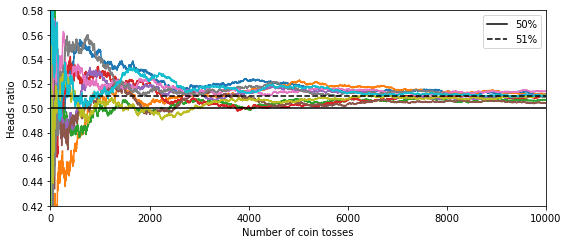

In [3]:
fig, axes = plt.subplots(figsize = (8, 3.5))
axes.plot(cumulative_heads_ratio)
axes.axhline(y = 0.50, color = 'black', linestyle = 'solid', label = '50%')
axes.axhline(y = 0.51, color = 'black', linestyle = 'dashed', label = '51%')
axes.set_xlim(0, coin_tosses.shape[0])
axes.set_ylim(0.42, 0.58)
axes.set_xlabel('Number of coin tosses')
axes.set_ylabel('Heads ratio')
axes.legend()
fig.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [6]:
voting_clf.fit(X = X_train, y = y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X = X_train, y = y_train)
    y_pred = clf.predict(X = X_test)
    print(clf.__class__.__name__, accuracy_score(y_true = y_test, y_pred = y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [8]:
# Manual accuracy calculation for hard voting (reproduce values in previous cell)
log_clf_pred = log_clf.predict(X = X_test)
rnd_clf_pred = rnd_clf.predict(X = X_test)
svm_clf_pred = svm_clf.predict(X = X_test)
all_clf_pred = np.c_[log_clf_pred, rnd_clf_pred, svm_clf_pred]

hard_votes = []
for instance in all_clf_pred:
    values, counts = np.unique(instance, return_counts = True)
    hard_vote = values[np.argmax(counts)]
    hard_votes.append(hard_vote)

for classifier, predictions in (('LogisticRegression', log_clf_pred), ('RandomForestClassifier', rnd_clf_pred), ('SVC', svm_clf_pred), ('VotingClassifier', hard_votes)):
    accuracy = sum(true == pred for true, pred in zip(y_test, predictions)) / len(y_test)
    print(classifier, accuracy)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [9]:
log_clf = LogisticRegression(solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = 'scale', probability = True, random_state = 42) # Page 194 of the textbook about setting probability = True

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')

In [10]:
voting_clf.fit(X = X_train, y = y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [11]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X = X_train, y = y_train)
    y_pred = clf.predict(X = X_test)
    print(clf.__class__.__name__, accuracy_score(y_true = y_test, y_pred = y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [12]:
# Manual accuracy calculation for soft voting (reproduce values in previous cell)
log_clf_pred_proba = log_clf.predict_proba(X = X_test)
rnd_clf_pred_proba = rnd_clf.predict_proba(X = X_test)
svm_clf_pred_proba = svm_clf.predict_proba(X = X_test)
all_clf_pred_proba_0 = np.c_[log_clf_pred_proba[:, 0], rnd_clf_pred_proba[:, 0], svm_clf_pred_proba[:, 0]]
all_clf_pred_proba_1 = np.c_[log_clf_pred_proba[:, 1], rnd_clf_pred_proba[:, 1], svm_clf_pred_proba[:, 1]]

soft_votes = []
for instance_0, instance_1 in zip(all_clf_pred_proba_0, all_clf_pred_proba_1):
    average_0 = np.mean(instance_0)
    average_1 = np.mean(instance_1)
    if average_0 > average_1:
        soft_votes.append(0)
    else:
        soft_votes.append(1)
for classifier, predictions in (('LogisticRegression', log_clf_pred), ('RandomForestClassifier', rnd_clf_pred), ('SVC', svm_clf_pred), ('VotingClassifier', soft_votes)):
    accuracy = sum(true == pred for true, pred in zip(y_test, predictions)) / len(y_test)
    print(classifier, accuracy)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting in Scikit-Learn 

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500,
    max_samples = 100,
    bootstrap = True,
    random_state = 42)
bag_clf.fit(X = X_train, y = y_train)
y_pred = bag_clf.predict(X = X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred = y_pred, y_true = y_test))

0.904


In [15]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X = X_train, y = y_train)
y_pred_tree = tree_clf.predict(X = X_test)
print(accuracy_score(y_pred = y_pred_tree, y_true = y_test))

0.856


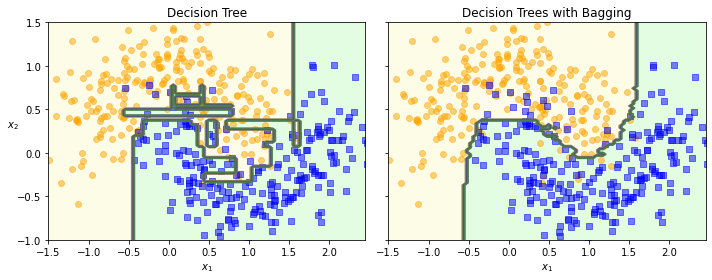

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(axes, clf, X, y, limits = [-1.5, 2.45, -1, 1.5], alpha = 0.5, contour = True):
    x1s = np.linspace(limits[0], limits[1], 100)
    x2s = np.linspace(limits[2], limits[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X = X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    axes.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    if contour:
        custom_cmap = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        axes.contour(x1, x2, y_pred, cmap = custom_cmap, alpha = 0.8)
    axes.scatter(x = X[y == 0, 0], y = X[y == 0, 1], color = 'orange', marker = 'o', alpha = alpha)
    axes.scatter(x = X[y == 1, 0], y = X[y == 1, 1], color = 'blue', marker = 's', alpha = alpha)
    axes.axis(limits)
    axes.set_xlabel('$x_{1}$')
    axes.set_ylabel('$x_{2}$', rotation = 0)
    
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), sharey = True)
plot_decision_boundary(axes[0], tree_clf, X, y)
plot_decision_boundary(axes[1], bag_clf, X, y)
axes[0].set_title('Decision Tree')
axes[1].set_title('Decision Trees with Bagging')
axes[1].set_ylabel('')
fig.tight_layout()
plt.show()

# Out-of-Bag Evaluation

In [17]:
bag_clf = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500,
    bootstrap = True,
    oob_score = True,
    random_state = 40)
bag_clf.fit(X = X_train, y = y_train)
print(bag_clf.oob_score_)

0.8986666666666666


In [18]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [19]:
y_pred = bag_clf.predict(X = X_test)
print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.912


In [20]:
print(len(X_train))
print(len(bag_clf.oob_decision_function_))

375
375


# Random Forests

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, random_state = 42)
rnd_clf.fit(X = X_train, y = y_train)

y_pred_rf = rnd_clf.predict(X = X_test)

In [22]:
bag_clf = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_features = 'sqrt', max_leaf_nodes = 16),
    n_estimators = 500,
    random_state = 42)

bag_clf.fit(X = X_train, y = y_train)
y_pred = bag_clf.predict(X = X_test)

In [23]:
print(np.all(y_pred_rf == y_pred))
print(np.sum(y_pred_rf == y_pred) / len(y_pred))

True
1.0


# Feature Importance

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(X = iris['data'], y = iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


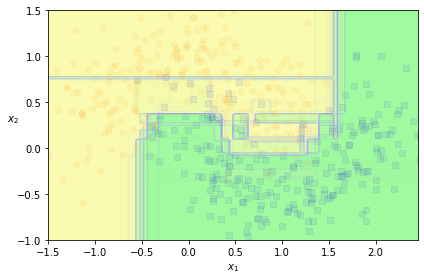

In [25]:
fig, axes = plt.subplots(figsize = (6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X = X_train[indices_with_replacement], y = y_train[indices_with_replacement])
    plot_decision_boundary(axes, tree_clf, X, y, limits = [-1.5, 2.45, -1, 1.5], alpha = 0.02, contour = False)

fig.tight_layout()
plt.show()

In [26]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.target = mnist.target.astype(np.uint8)

In [27]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(X = mnist['data'], y = mnist['target'])

RandomForestClassifier(random_state=42)

In [28]:
print(rnd_clf.feature_importances_.shape)
print(mnist.target.shape)
print(mnist.data.shape)

(784,)
(70000,)
(70000, 784)


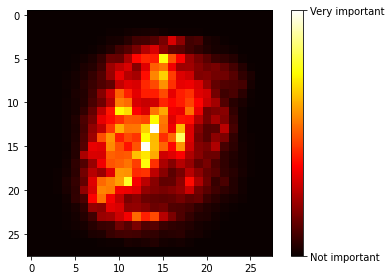

In [29]:
import matplotlib.cm as cm

fig, axes = plt.subplots()

image = axes.imshow(X = rnd_clf.feature_importances_.reshape(28, 28), interpolation = 'nearest', cmap = cm.hot)
color_bar = fig.colorbar(mappable = image,
                         ticks = [rnd_clf.feature_importances_.min(),
                                  rnd_clf.feature_importances_.max()])
color_bar.ax.set_yticklabels(['Not important', 'Very important'])
fig.tight_layout()
plt.show()

# AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    n_estimators = 200,
    algorithm = 'SAMME.R',
    learning_rate = 0.5,
    random_state = 42)
ada_clf.fit(X = X_train, y = y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

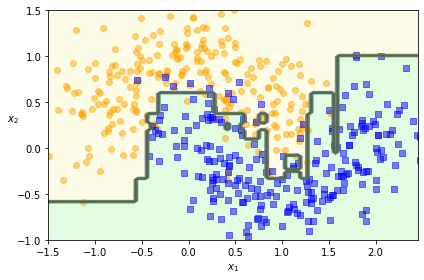

In [31]:
fig, axes = plt.subplots()
plot_decision_boundary(axes, ada_clf, X, y)
fig.tight_layout()
plt.show()

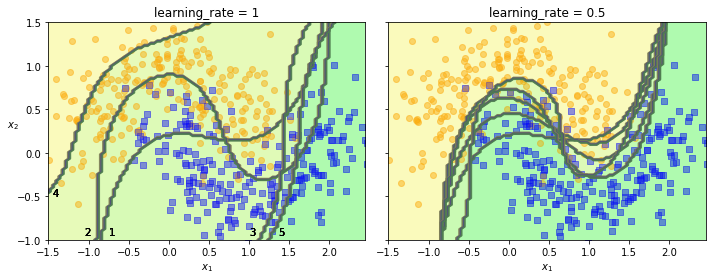

In [32]:
m = len(X_train)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), sharey = True)

for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    for i in range(5):
        svm_clf = SVC(kernel = 'rbf', C = 0.2, gamma = 0.6, random_state = 42)
        svm_clf.fit(X = X_train, y = y_train, sample_weight = sample_weights * m) # I need to understand where the " * m" is coming from
        y_pred = svm_clf.predict(X = X_train)
        
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # Equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # Equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # Equation 7-3
        sample_weights /= sample_weights.sum() # Normalization, page 204
        
        plot_decision_boundary(axes[subplot], svm_clf, X, y, alpha = 0.2)
        axes[subplot].set_title(f'learning_rate = {learning_rate}')

        if subplot == 0:
            axes[subplot].text(x = -0.75, y = -0.95, s = '1')
            axes[subplot].text(x = -1.05, y = -0.95, s = '2')
            axes[subplot].text(x = 1.000, y = -0.95, s = '3')
            axes[subplot].text(x = -1.45, y = -0.50, s = '4')
            axes[subplot].text(x = 1.360, y = -0.95, s = '5')
        else:
            axes[subplot].set_ylabel('')
        
fig.tight_layout()
plt.show()

In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    n_estimators = 200,
    algorithm = 'SAMME.R',
    learning_rate = 0.5)
ada_clf.fit(X = X_train, y = y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

# Gradient Boosting

In [34]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

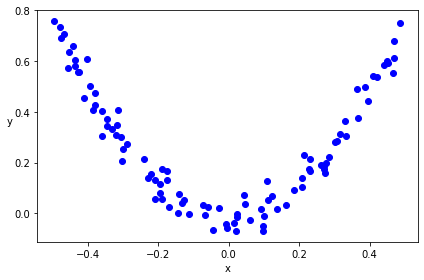

In [35]:
fig, axes = plt.subplots()
axes.scatter(x = X, y = y, color = 'blue', marker = 'o')
axes.set_xlabel('x')
axes.set_ylabel('y', rotation = 0)
fig.tight_layout()
plt.show()

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X = X, y = y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [37]:
y2 = y - tree_reg1.predict(X = X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X = X, y = y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [38]:
y3 = y2 - tree_reg2.predict(X = X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg3.fit(X = X, y = y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
X_new = np.array([[0.4]])

In [40]:
y_pred = sum(tree.predict(X = X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [41]:
print(y_pred)

[0.49995198]


In [42]:
def plot_predictions(axes, regressors, X, y, limits, label = None, style = 'r-', data_style = 'b.', data_label = None):
    x1 = np.linspace(limits[0], limits[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    axes.plot(X[:, 0], y, data_style, label = data_label)
    axes.plot(x1, y_pred, style, linewidth = 2, label = label)
    if label or data_label:
        axes.legend(loc = 'upper center', fontsize = 16)
    axes.axis(limits)

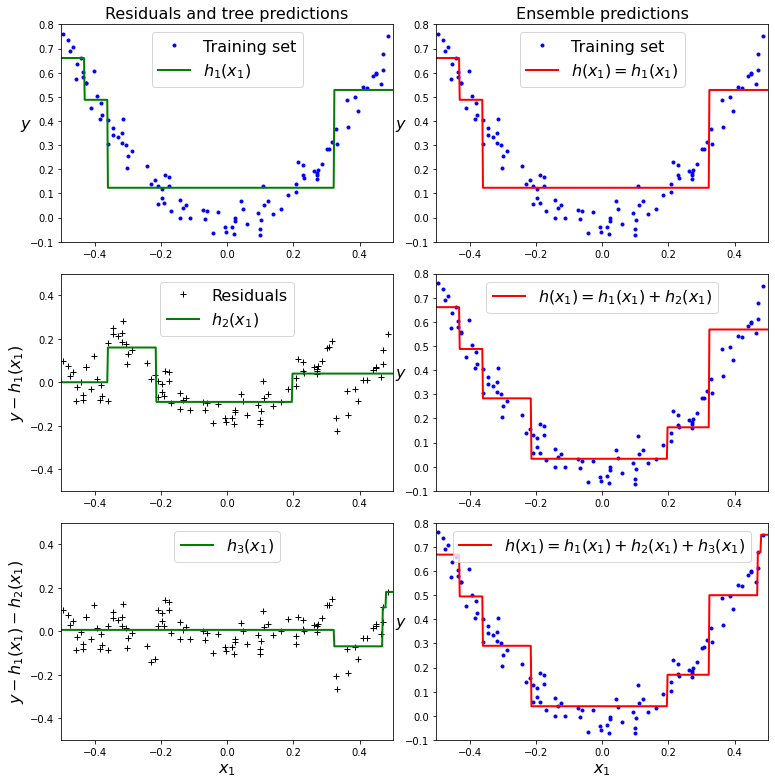

In [43]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (11, 11))

plot_predictions(axes[0, 0], [tree_reg1], X, y, limits = [-0.5, 0.5, -0.1, 0.8], label = '$h_{1}(x_{1})$', style = 'g-', data_label = 'Training set')
plot_predictions(axes[0, 1], [tree_reg1], X, y, limits = [-0.5, 0.5, -0.1, 0.8], label = '$h(x_{1}) = h_{1}(x_{1})$', data_label = 'Training set')
plot_predictions(axes[1, 0], [tree_reg2], X, y2, limits = [-0.5, 0.5, -0.5, 0.5], label = '$h_{2}(x_{1})$', style = 'g-', data_style = 'k+', data_label = 'Residuals')
plot_predictions(axes[1, 1], [tree_reg1, tree_reg2], X, y, limits = [-0.5, 0.5, -0.1, 0.8], label = '$h(x_{1}) = h_{1}(x_{1}) + h_{2}(x_{1})$')
plot_predictions(axes[2, 0], [tree_reg3], X, y3, limits = [-0.5, 0.5, -0.5, 0.5], label = '$h_{3}(x_{1})$', style = 'g-', data_style = 'k+')
plot_predictions(axes[2, 1], [tree_reg1, tree_reg2, tree_reg3], X, y, limits = [-0.5, 0.5, -0.1, 0.8], label = '$h(x_{1}) = h_{1}(x_{1}) + h_{2}(x_{1}) + h_{3}(x_{1})$')

axes[0, 0].set_title('Residuals and tree predictions', fontsize = 16)
axes[0, 1].set_title('Ensemble predictions', fontsize = 16)

axes[0, 0].set_ylabel('$y$', fontsize = 16, rotation = 0)
axes[0, 1].set_ylabel('$y$', fontsize = 16, rotation = 0)
axes[1, 0].set_ylabel('$y-h_{1}(x_{1})$', fontsize = 16)
axes[1, 1].set_ylabel('$y$', fontsize = 16, rotation = 0)
axes[2, 0].set_ylabel('$y-h_{1}(x_{1})-h_{2}(x_{1})$', fontsize = 16)
axes[2, 1].set_ylabel('$y$', fontsize = 16, rotation = 0)
axes[2, 0].set_xlabel('$x_{1}$', fontsize = 16)
axes[2, 1].set_xlabel('$x_{1}$', fontsize = 16)

fig.tight_layout()
plt.show()

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0, random_state = 42)
gbrt.fit(X = X, y = y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [45]:
gbrt_slow = GradientBoostingRegressor(max_depth = 2, n_estimators = 200, learning_rate = 0.1, random_state = 42)
gbrt_slow.fit(X = X, y = y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

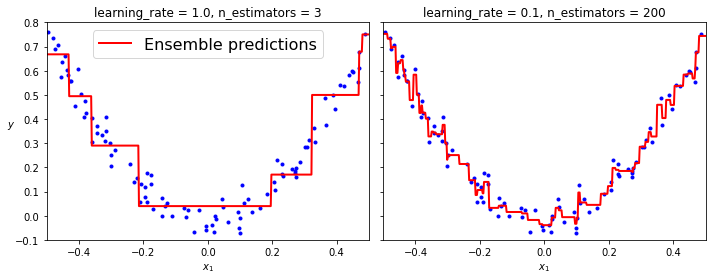

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), sharey = True)

plot_predictions(axes[0], [gbrt], X, y, limits = [-0.5, 0.5, -0.1, 0.8], label = 'Ensemble predictions')
axes[0].set_title(f'learning_rate = {gbrt.learning_rate}, n_estimators = {gbrt.n_estimators}')

plot_predictions(axes[1], [gbrt_slow], X, y, limits = [-0.5, 0.5, -0.1, 0.8])
axes[1].set_title(f'learning_rate = {gbrt_slow.learning_rate}, n_estimators = {gbrt_slow.n_estimators}')

axes[0].set_xlabel('$x_{1}$')
axes[1].set_xlabel('$x_{1}$')
axes[0].set_ylabel('$y$', rotation = 0)
fig.tight_layout()
plt.show()

In [47]:
# Gradient boosting with early stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 49)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120, random_state = 42)
gbrt.fit(X = X_train, y = y_train)

errors = [mean_squared_error(y_true = y_val, y_pred = y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
print(bst_n_estimators)

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators, random_state = 42)
gbrt_best.fit(X = X_train, y = y_train)

assert gbrt.n_estimators == len(errors)

56


In [48]:
min_error = np.min(errors)
print(min_error)

0.002712853325235463


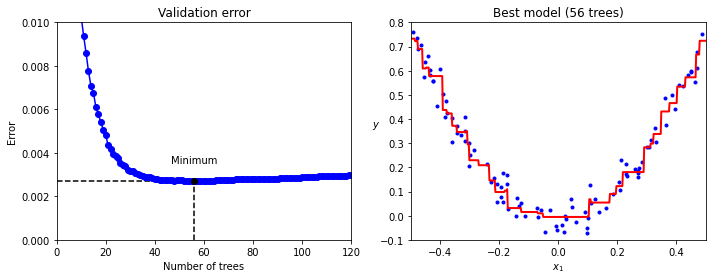

In [49]:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 4))

#axes[0].plot(errors, color = 'blue', marker = 'o') # off-by-one error in author's notebook
#axes[0].plot(list(range(1, len(errors) + 1)), errors, color = 'blue', marker = 'o')
axes[0].plot(np.arange(1, len(errors) + 1), errors, color = 'blue', marker = 'o')
axes[0].set_title('Validation error')
axes[0].set_xlabel('Number of trees')
axes[0].set_ylabel('Error')
axes[0].set_xlim(0, 120)
axes[0].set_ylim(0, 0.01)
#axes[0].set_xlim(50, 60)
#axes[0].set_ylim(0.00270, 0.00275)
axes[0].hlines(y = min_error, xmin = axes[0].get_xlim()[0], xmax = bst_n_estimators, color = 'black', linestyle = 'dashed')
axes[0].vlines(x = bst_n_estimators, ymin = axes[0].get_ylim()[0], ymax = min_error, color = 'black', linestyle = 'dashed')
axes[0].plot(bst_n_estimators, min_error, color = 'black', marker = 'o')
axes[0].text(bst_n_estimators, min_error * 1.3, 'Minimum', horizontalalignment = 'center')

plot_predictions(axes[1], [gbrt_best], X, y, limits = [-0.5, 0.5, -0.1, 0.8])
axes[1].set_title(f'Best model ({bst_n_estimators} trees)')
axes[1].set_xlabel('$x_{1}$')
axes[1].set_ylabel('$y$', rotation = 0)

fig.tight_layout()
plt.show()

In [50]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True, random_state = 42)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X = X_train, y = y_train)
    y_pred = gbrt.predict(X = X_val)
    val_error = mean_squared_error(y_true = y_val, y_pred = y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [51]:
print(gbrt.n_estimators)
assert gbrt.n_estimators - 5 == bst_n_estimators

61


In [52]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state = 42)
xgb_reg.fit(X = X_train, y = y_train)
y_pred = xgb_reg.predict(X = X_val)
val_error = mean_squared_error(y_true = y_val, y_pred = y_pred)
print('Validation MSE:', val_error)

Validation MSE: 0.004000408205406276


In [53]:
xgb_reg.fit(X = X_train, y = y_train,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X = X_val)
val_error = mean_squared_error(y_true = y_val, y_pred = y_pred)
print('Validation MSE:', val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


In [54]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

42.5 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

18.1 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise 1

Page 192: Since they are different models, a "simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes."
This aggregation would be a voting classifier, either a hard voting classifier or soft voting classifier.
This will work since the models are different, and would work better if the models were trained on different training instances.

# Exercise 2

A hard voting classifier (page 192) is a majority-vote classifier (that is, it aggregates the predictions of each classifier in the ensemble and predicts the class that receives the most votes).
A soft voting classifier (page 194) predicts the class with the highest class probability, averaged over all the individual classifiers in the ensemble.
Page 194: a soft voting classifier often achieves higher performance than hard voting because it gives more weight to highly confident votes.
As explained on page 194, the classifiers in the ensemble must be able to estimate class probabilities.

See my manual calculation for the accuracy of a soft- and hard-voting classifier earlier in this notebook.

# Exercise 3

* **bagging ensembles** - Yes. Page 196: Predictors can be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.
* **pasting ensembles** - Yes. See answer for bagging ensembles.
* **boosting ensembles** - No. Page 201: The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. Page 203: There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging and pasting. 
* **random forests** - Yes (same answer as bagging ensembles)
* **stacking ensembles** - All the predictors in a given layer are independent of each other, so they can be trained in parallel across multiple servers. However, the predictors in next layer can only be trained once the predictors in the previous layer have all been trained.

# Exercise 4

Page 197: Since a predictor never sees the out-of-bag (oob) instances during training, it can be evaluated on these instances, without the need for a separate validation set.
You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

Since there is no need for a separate validation set, more instances are available for training.

# Exercise 5

Page 200: "When you are growing a tree in a Random Forest, at each node only a random subset of features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than search for the best possible thresholds (like regular Decision Trees do).
A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble (or *Extra-Trees* for short). Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.
It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

# Exercise 6

Page 205: "If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularize the base estimator."

Therefore, if the AdaBoost ensemble *underfits* the training data, I would try increasing the number of estimators or decreasing the regularization of the base estimator.

# Exercise 7

See pages 207-208 and figure 7-10.

Try decreasing the learning rate. Also use early stopping to determine the optimal number of trees (with overfitting, there are too many trees).

# Exercise 8

In [56]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)

In [57]:
mnist.target = mnist.target.astype(np.uint8)

In [58]:
from sklearn.model_selection import train_test_split

# X_train_val and y_train_val are only used in this cell
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size = 10000, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size = 10000, random_state = 42)

In [59]:
print(X_train_val.shape)
print(y_train_val.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

assert X_train.shape[0] == 50000
assert y_train.shape[0] == 50000
assert X_val.shape[0] == 10000
assert y_val.shape[0] == 10000
assert X_test.shape[0] == 10000
assert y_test.shape[0] == 10000

(60000, 784)
(60000,)
(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


In [60]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [61]:
random_forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
extra_trees_clf = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
svc_clf = LinearSVC(max_iter = 100, tol = 20, random_state = 42)
mlp_clf = MLPClassifier(random_state = 42)

In [62]:
estimators = [random_forest_clf, extra_trees_clf, svc_clf, mlp_clf]
for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X = X_train, y = y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [63]:
from sklearn.metrics import accuracy_score

for estimator in estimators:
    y_pred = estimator.predict(X = X_val)
    print(estimator,
          accuracy_score(y_true = y_val, y_pred = y_pred),
          estimator.score(X = X_val, y = y_val))

RandomForestClassifier(random_state=42) 0.9692 0.9692
ExtraTreesClassifier(random_state=42) 0.9715 0.9715
LinearSVC(max_iter=100, random_state=42, tol=20) 0.859 0.859
MLPClassifier(random_state=42) 0.963 0.963


In [64]:
from sklearn.ensemble import VotingClassifier

In [65]:
named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svc_clf', svc_clf),
    ('mlp_clf', mlp_clf)
]

In [66]:
voting_clf = VotingClassifier(
    estimators = named_estimators,
    voting = 'hard')

In [67]:
voting_clf.fit(X = X_train, y = y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svc_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [68]:
print(voting_clf.score(X = X_val, y = y_val))
y_pred = voting_clf.predict(X = X_val)
print(accuracy_score(y_true = y_val, y_pred = y_pred))

0.9704
0.9704


In [69]:
for estimator in voting_clf.estimators_:
    y_pred = estimator.predict(X = X_val)
    print(estimator,
          accuracy_score(y_true = y_val, y_pred = y_pred),
          estimator.score(X = X_val, y = y_val))

RandomForestClassifier(random_state=42) 0.9692 0.9692
ExtraTreesClassifier(random_state=42) 0.9715 0.9715
LinearSVC(max_iter=100, random_state=42, tol=20) 0.859 0.859
MLPClassifier(random_state=42) 0.963 0.963


In [70]:
# Try removing SVM to see if performance improves
voting_clf.set_params(svc_clf = None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svc_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [71]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svc_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [72]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [73]:
del voting_clf.estimators_[2]

In [74]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 MLPClassifier(random_state=42)]

In [75]:
print(voting_clf.score(X = X_val, y = y_val))
y_pred = voting_clf.predict(X = X_val)
print(accuracy_score(y_true = y_val, y_pred = y_pred))

0.9741
0.9741


In [76]:
voting_clf.voting = 'soft'

In [77]:
print(voting_clf.score(X = X_val, y = y_val))
y_pred = voting_clf.predict(X = X_val)
print(accuracy_score(y_true = y_val, y_pred = y_pred))

0.9711
0.9711


In [78]:
# hard voting is better for this case, so switch back
voting_clf.voting = 'hard'

In [79]:
print(voting_clf.score(X = X_test, y = y_test))
y_pred = voting_clf.predict(X = X_test)
print(accuracy_score(y_true = y_test, y_pred = y_pred))

0.9706
0.9706


In [80]:
for estimator in voting_clf.estimators_:
    y_pred = estimator.predict(X = X_test)
    print(estimator,
          accuracy_score(y_true = y_test, y_pred = y_pred),
          estimator.score(X = X_test, y = y_test))

RandomForestClassifier(random_state=42) 0.9645 0.9645
ExtraTreesClassifier(random_state=42) 0.9691 0.9691
MLPClassifier(random_state=42) 0.9573 0.9573


The voting classifier slightly increased the accuracy of the best model

# Exercise 9

In [81]:
random_forest_pred = random_forest_clf.predict(X = X_val)
extra_trees_pred = extra_trees_clf.predict(X = X_val)
svc_pred = svc_clf.predict(X = X_val)
mlp_pred = mlp_clf.predict(X = X_val)

In [82]:
X_val_predictions = np.c_[random_forest_pred, extra_trees_pred, svc_pred, mlp_pred]

In [83]:
X_val_predictions

array([[5, 5, 5, 5],
       [8, 8, 8, 8],
       [2, 2, 3, 2],
       ...,
       [7, 7, 7, 7],
       [6, 6, 6, 6],
       [7, 7, 7, 7]], dtype=uint8)

In [84]:
rnd_forest_blender = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 42)
rnd_forest_blender.fit(X = X_val_predictions, y = y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [85]:
rnd_forest_blender.oob_score_

0.9691

Now evaluate with the test set

In [86]:
random_forest_pred = random_forest_clf.predict(X = X_test)
extra_trees_pred = extra_trees_clf.predict(X = X_test)
svc_pred = svc_clf.predict(X = X_test)
mlp_pred = mlp_clf.predict(X = X_test)

In [87]:
X_test_predictions = np.c_[random_forest_pred, extra_trees_pred, svc_pred, mlp_pred]

In [88]:
y_pred = rnd_forest_blender.predict(X = X_test_predictions)

In [89]:
print(accuracy_score(y_true = y_test, y_pred = y_pred))
print(rnd_forest_blender.score(X_test_predictions, y_test))

0.9667
0.9667


This stacking ensemble is not as accurate as the voting classifier (or best individual classifier) from the previous exercise.